<a href="https://colab.research.google.com/github/rajashekar/colab/blob/main/train_pass_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/Colab/password/

/content/drive/MyDrive/Colab/password


In [ ]:
import os
import time

import tensorflow as tf

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


In [ ]:
data = open('data/passwords_db.txt',).read()

In [ ]:
len(data)

178313552

In [ ]:
passwds = data.split("\n")

In [ ]:
len(passwds)

18308617

# Vectorize the text

In [ ]:
vocab = sorted(list(set(''.join(passwds))))

In [ ]:
len(vocab)

95

In [ ]:
char_indices = dict((c, i) for i, c in enumerate(vocab))
indices_char = dict((i, c) for i, c in enumerate(vocab))

In [ ]:
max_len = max(passwds, key=len)

In [ ]:
len(max_len)

50

In [ ]:
print(f"Total number of passwords {len(passwds)}")
print(f"Passwords vocab size {len(vocab)}")
print(f"Max passwords length {len(max_len)}")

Total number of passwords 18308617
Passwords vocab size 95
Max passwords length 50


In [ ]:
input_text = [p[:-1] for p in passwds]
target_text = [p[1:] for p in passwds]

In [ ]:
print(f"{passwds[0]} {input_text[0]} {target_text[0]}")

12STEVEN 12STEVE 2STEVEN


In [ ]:
# Creating like below will blow memory

# input_data = np.zeros( (len(passwds), len(max_len), len(vocab)) ,dtype='float32')
# target_data = np.zeros( (len(passwds), len(max_len), len(vocab)) ,dtype='float32')

# nearly took 17 GB of RAM memory for 1 million records
# dataset has 14 million records
# one_m_records = np.zeros( (1000000, 50, 95) ,dtype='float32')

# clean memory
# del one_m_records


In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', char_level=True, lower=False)
tokenizer.fit_on_texts(passwds)

In [ ]:
input_tensor = tokenizer.texts_to_sequences(input_text)
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, padding='post')

In [ ]:
input_tensor.shape

In [ ]:
target_tensor = tokenizer.texts_to_sequences(target_text)
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, padding='post')

In [ ]:
target_tensor.shape

In [ ]:
[''.join(i.split()) for i in tokenizer.sequences_to_texts(input_tensor[:5])]

In [ ]:
[''.join(i.split()) for i in tokenizer.sequences_to_texts(target_tensor[:5])]

In [ ]:
len(tokenizer.word_index)

# Split data into Train and Validation

In [ ]:
# Batch size
BATCH_SIZE = 32

# Buffer size to shuffle the dataset
BUFFER_SIZE = 10000

# split to 70 30 
input_tensor_train, input_tensor_rem, target_tensor_train, target_tensor_rem = train_test_split(input_tensor, target_tensor, test_size=0.3, shuffle=True)

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# split to 50 50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_rem, target_tensor_rem, test_size=0.5)

val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# For performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

max_length_input = input_tensor.shape[1]
max_length_output = target_tensor.shape[1]

embedding_dim = vocab_size
rnn_units = 2048

print(f'Vocab size {vocab_size}')
print(f"Max input length {max_length_input}")
print(f"Max input length {max_length_output}")

In [ ]:
input_tensor_train.shape

# Create Model

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.lstm.get_initial_state(x)
    x, states_h, states_c = self.lstm(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states_h, states_c
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
# try model without training
for input_example_batch, target_example_batch in train_dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(32, 49, 96) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  9216      
                                                                 
 lstm (LSTM)                 multiple                  17571840  
                                                                 
 dense (Dense)               multiple                  196704    
                                                                 
Total params: 17,777,760
Trainable params: 17,777,760
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input_example_batch

<tf.Tensor: shape=(32, 49), dtype=int32, numpy=
array([[ 6, 31, 10, ...,  0,  0,  0],
       [ 3, 14,  4, ...,  0,  0,  0],
       [15, 23,  9, ...,  0,  0,  0],
       ...,
       [ 6,  6, 14, ...,  0,  0,  0],
       [10,  7,  5, ...,  0,  0,  0],
       [26, 23,  9, ...,  0,  0,  0]], dtype=int32)>

In [ ]:
tf.random.categorical(example_batch_predictions[0], num_samples=1)

<tf.Tensor: shape=(49, 1), dtype=int64, numpy=
array([[69],
       [79],
       [38],
       [66],
       [15],
       [81],
       [95],
       [23],
       [46],
       [32],
       [69],
       [85],
       [ 6],
       [44],
       [87],
       [65],
       [35],
       [24],
       [54],
       [40],
       [81],
       [49],
       [67],
       [56],
       [14],
       [65],
       [95],
       [35],
       [76],
       [56],
       [33],
       [10],
       [94],
       [39],
       [ 6],
       [14],
       [60],
       [53],
       [19],
       [22],
       [ 2],
       [63],
       [78],
       [10],
       [82],
       [32],
       [17],
       [ 2],
       [ 7]])>

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
[tf.squeeze(tf.random.categorical(pred, num_samples=1), axis=-1).numpy() for pred in example_batch_predictions] 

[array([95, 41,  7, 13,  7,  6, 36, 49, 13, 27, 18, 68, 60, 37, 76, 85, 76,
        71, 38, 35, 77, 32, 83, 29, 42, 63, 52, 93, 81, 67, 11, 92,  1, 55,
        89, 46, 82, 79, 31, 14, 50, 31, 68, 36, 94,  4, 45, 54, 20]),
 array([69, 31, 28, 29, 47, 94, 91, 73,  2, 70, 68, 50, 73, 89, 31, 95, 80,
        44, 45, 72,  1, 75, 36, 31, 84, 28, 10, 26, 84,  4, 25, 60, 93, 38,
        35, 35, 74, 15, 64, 61, 10, 46, 12, 17, 70, 59, 55, 49, 24]),
 array([89, 83, 47, 47, 69, 63, 83, 58, 16, 52, 44, 95, 86, 94, 53,  5, 33,
        76, 47, 83, 27, 36, 50, 66, 12, 57, 43, 29, 28,  6, 80, 63, 15, 64,
        94, 71, 93, 90, 82, 12, 81, 39, 52, 68, 72, 24, 43, 56, 79]),
 array([76,  2, 26, 12, 43, 15, 74, 71, 58, 67, 23,  4, 77, 58, 49, 12, 19,
        64, 44, 64, 81, 62, 81, 65, 21,  6, 42, 12, 22, 31, 17, 44, 11, 69,
        50, 63, 17, 82, 15, 46, 66, 59, 86, 81, 78, 30,  8, 20, 52]),
 array([25, 22,  4,  4, 32, 14, 78, 63, 56, 63, 79,  3, 36, 92, 20, 79, 43,
        41, 31, 37, 22, 41, 29, 88, 

In [ ]:
tokenizer.sequences_to_texts([tf.squeeze(tf.random.categorical(pred, num_samples=1), axis=-1).numpy() for pred in example_batch_predictions] )

['R Z O 5 e L `   1 | R Y T m Z " j z L ! Q r ] S * Y b a 6 I v = g F   9 Y . L y I { 4 k R / { o =',
 'P ^ F l 5 Q l ( ( . } G H Y ^ W 8 B 5 Y 8 f % X a U q a m | K 7 l a = l e { e % F h } j * 9 C f 5',
 'D M c s g 1 ) p y i c = ^ 3 U - . D } " E r a _ # D a H [ < ; O K b { ` Z V [ k m k S 1 ` U 1 D',
 "k 0 O [ = u n : P * H R v J M q | 4 = S u z   z m [ 3 / F n % c ' F Y 4 \\ P 9 ( 6 - w 8 9 Z 7 E %",
 'a k K R _ N C C # A w ( b ^ s Q ! l R i Z W I 5 8 J ^ y : \\ v r d t ? C y u ~ / P q y w % } I | P',
 "c f \\ F / : W S | | -   e \\ } 6 Q l Y { M d K C Z f Y * f + Q w z & I V v ) 8 d > H * i ' w j | ,",
 '\' 4 m E G G d ; U @ ^ A 3 s ` B " * B y = m j ^ f K j . ] @ n ] r e { u : { ^ > 9 W = $ $ 5 f ]',
 '] $ & ^ c w ` j & o l U ^ u M   / K < } 8 G ^ f R a - z H d ~ d r N [ q # > C + Z F 7 9 n " O r w',
 "- d | Q U [ z ( o z ' ) l ( ~ A d & O ` R F t ' [ | @ s 9 w $ x p A L w 7 ) | n ] Z C ) 7 p   >",
 'c Y E * k $ W | ; R q r ( N # z q P [ = Q S ` s P x i C ] y 2 9 / %   p C Q f _ o

In [ ]:
sampled_indices

array([ 9, 33, 30, 90, 21, 58, 47, 20, 63, 26,  1,  1,  7, 25, 87, 38, 73,
       91, 10, 40, 65, 62, 94, 88,  5, 45,  2,  0, 22, 92, 89, 69, 31, 75,
       27,  9, 73, 23, 85, 93, 41, 42, 86,  7, 91, 46,  8, 64, 94])

In [ ]:
input_example_batch[0].numpy()

array([ 6, 31, 10,  5,  9, 15, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [ ]:
print(f"Input: {[''.join(i.split()) for i in tokenizer.sequences_to_texts([input_example_batch[0].numpy()]) ]}")
print(f"next char prediction : {[''.join(i.split()) for i in tokenizer.sequences_to_texts([sampled_indices]) ]}")

Input: ['2flirt4']
next char prediction : ['rwj`cJDm*baaoy[I,"lRW@}:iTed>^#f&kr,u<{SL~o"CnV}']


# Train Model

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (32, 49, 96)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.5686297, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

96.41191

In [ ]:
input_example_batch.numpy()

array([[ 6, 31, 10, ...,  0,  0,  0],
       [ 3, 14,  4, ...,  0,  0,  0],
       [15, 23,  9, ...,  0,  0,  0],
       ...,
       [ 6,  6, 14, ...,  0,  0,  0],
       [10,  7,  5, ...,  0,  0,  0],
       [26, 23,  9, ...,  0,  0,  0]], dtype=int32)

In [ ]:
tokenizer.sequences_to_texts(input_example_batch.numpy())

['2 f l i r t 4',
 '1 8 0 7 9 2',
 't u r c a 1 0 3 8',
 't o o l f a n 7',
 '3 3 4 4 2 8',
 'm o m o g',
 'g e n g u',
 'i n s t p o i l 7',
 't u n g g',
 '6 9 3 7 8 6 3',
 'w e r o 8 4 8',
 'k a s e y e v e r h a',
 'o t t a n t u n',
 '0 9 4 0 0 1 6 9',
 'f u c k a z 1',
 '7 6 9 5 9',
 'a m y r i s n e',
 'k e l l i e j a n',
 'k u z a i m a',
 'w h 6 3 9 6 3',
 's c 2 5 2',
 'n o n a 9',
 'a s w 2 0 0',
 'm a x k y k',
 'R U B Y R I V E',
 'j e r e s c',
 'a m a t e r',
 's a p h a r i 1',
 'q w e r 1 3 5 7',
 '2 2 8 9 2 7 3',
 'l o i u',
 'b u r a k']

In [ ]:
[p.split() for p in tokenizer.sequences_to_texts(input_example_batch.numpy())]

[['2', 'f', 'l', 'i', 'r', 't', '4'],
 ['1', '8', '0', '7', '9', '2'],
 ['t', 'u', 'r', 'c', 'a', '1', '0', '3', '8'],
 ['t', 'o', 'o', 'l', 'f', 'a', 'n', '7'],
 ['3', '3', '4', '4', '2', '8'],
 ['m', 'o', 'm', 'o', 'g'],
 ['g', 'e', 'n', 'g', 'u'],
 ['i', 'n', 's', 't', 'p', 'o', 'i', 'l', '7'],
 ['t', 'u', 'n', 'g', 'g'],
 ['6', '9', '3', '7', '8', '6', '3'],
 ['w', 'e', 'r', 'o', '8', '4', '8'],
 ['k', 'a', 's', 'e', 'y', 'e', 'v', 'e', 'r', 'h', 'a'],
 ['o', 't', 't', 'a', 'n', 't', 'u', 'n'],
 ['0', '9', '4', '0', '0', '1', '6', '9'],
 ['f', 'u', 'c', 'k', 'a', 'z', '1'],
 ['7', '6', '9', '5', '9'],
 ['a', 'm', 'y', 'r', 'i', 's', 'n', 'e'],
 ['k', 'e', 'l', 'l', 'i', 'e', 'j', 'a', 'n'],
 ['k', 'u', 'z', 'a', 'i', 'm', 'a'],
 ['w', 'h', '6', '3', '9', '6', '3'],
 ['s', 'c', '2', '5', '2'],
 ['n', 'o', 'n', 'a', '9'],
 ['a', 's', 'w', '2', '0', '0'],
 ['m', 'a', 'x', 'k', 'y', 'k'],
 ['R', 'U', 'B', 'Y', 'R', 'I', 'V', 'E'],
 ['j', 'e', 'r', 'e', 's', 'c'],
 ['a', 'm', 'a', 't', 

In [ ]:
import re
[re.findall('..?',"".join(p.split())) for p in tokenizer.sequences_to_texts(input_example_batch.numpy())]

[['2f', 'li', 'rt', '4'],
 ['18', '07', '92'],
 ['tu', 'rc', 'a1', '03', '8'],
 ['to', 'ol', 'fa', 'n7'],
 ['33', '44', '28'],
 ['mo', 'mo', 'g'],
 ['ge', 'ng', 'u'],
 ['in', 'st', 'po', 'il', '7'],
 ['tu', 'ng', 'g'],
 ['69', '37', '86', '3'],
 ['we', 'ro', '84', '8'],
 ['ka', 'se', 'ye', 've', 'rh', 'a'],
 ['ot', 'ta', 'nt', 'un'],
 ['09', '40', '01', '69'],
 ['fu', 'ck', 'az', '1'],
 ['76', '95', '9'],
 ['am', 'yr', 'is', 'ne'],
 ['ke', 'll', 'ie', 'ja', 'n'],
 ['ku', 'za', 'im', 'a'],
 ['wh', '63', '96', '3'],
 ['sc', '25', '2'],
 ['no', 'na', '9'],
 ['as', 'w2', '00'],
 ['ma', 'xk', 'yk'],
 ['RU', 'BY', 'RI', 'VE'],
 ['je', 're', 'sc'],
 ['am', 'at', 'er'],
 ['sa', 'ph', 'ar', 'i1'],
 ['qw', 'er', '13', '57'],
 ['22', '89', '27', '3'],
 ['lo', 'iu'],
 ['bu', 'ra', 'k']]

In [ ]:
def bleu_score(y_true, y_pred):
  true_seq = tokenizer.sequences_to_texts(y_true.numpy())
  reference = [p.split() if p.split() else [' '] for p in true_seq]
  preds = [tf.squeeze(tf.random.categorical(pred, num_samples=1), axis=-1).numpy() for pred in y_pred]
  hypothesis = [p.split() if p.split() else [' '] for p in tokenizer.sequences_to_texts(preds)]
  return corpus_bleu(reference, hypothesis)

In [ ]:
def bleu_score_bi(y_true, y_pred):
  true_seq = tokenizer.sequences_to_texts(y_true.numpy())
  reference = [re.findall('..?',"".join(p.split())) if p.split() else [' '] for p in true_seq]
  preds = [tf.squeeze(tf.random.categorical(pred, num_samples=1), axis=-1).numpy() for pred in y_pred]
  hypothesis = [re.findall('..?',"".join(p.split())) if p.split() else [' '] for p in tokenizer.sequences_to_texts(preds)]
  return corpus_bleu(reference, hypothesis)  

In [ ]:
bleu_score(input_example_batch, example_batch_predictions)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4722506447352589

In [ ]:
bleu_score_bi(input_example_batch, example_batch_predictions)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.18928475425929298

In [ ]:
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.006)

In [ ]:
# GPU
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

# Configure Checkpoints

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_lstm'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

earlystopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    patience = 3,
    restore_best_weights = True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only=True,
    save_weights_only=True, 
    verbose = 1)

In [ ]:
EPOCHS = 20

history = model.fit(train_dataset, 
                    validation_data=val_dataset,
                    epochs=EPOCHS, 
                    callbacks=[checkpoint_callback, earlystopping_cb])

Epoch 1/20
400498/400500 [============================>.] - ETA: 0s - loss: 0.4009 - accuracy: 0.8860
Epoch 1: val_accuracy improved from -inf to 0.88523, saving model to ./training_checkpoints_lstm/ckpt_1
400500/400500 [==============================] - 9626s 24ms/step - loss: 0.4009 - accuracy: 0.8860 - val_loss: 0.3939 - val_accuracy: 0.8852
Epoch 2/20
400500/400500 [==============================] - ETA: 0s - loss: 0.3923 - accuracy: 0.8884
Epoch 2: val_accuracy improved from 0.88523 to 0.88582, saving model to ./training_checkpoints_lstm/ckpt_2
400500/400500 [==============================] - 9532s 24ms/step - loss: 0.3923 - accuracy: 0.8884 - val_loss: 0.3920 - val_accuracy: 0.8858
Epoch 3/20
400500/400500 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.8892
Epoch 3: val_accuracy improved from 0.88582 to 0.88616, saving model to ./training_checkpoints_lstm/ckpt_3
400500/400500 [==============================] - 9550s 24ms/step - loss: 0.3895 - accuracy: 0.

In [ ]:
model.save('saved_model/password')

INFO:tensorflow:Assets written to: saved_model/password/assets


INFO:tensorflow:Assets written to: saved_model/password/assets


In [ ]:
model = tf.keras.models.load_model('saved_model/password')

In [ ]:
model.summary()

Model: "my_model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    multiple                  9216      
                                                                 
 lstm_3 (LSTM)               multiple                  17571840  
                                                                 
 dense_9 (Dense)             multiple                  196704    
                                                                 
Total params: 17,777,760
Trainable params: 17,777,760
Non-trainable params: 0
_________________________________________________________________


# Plot

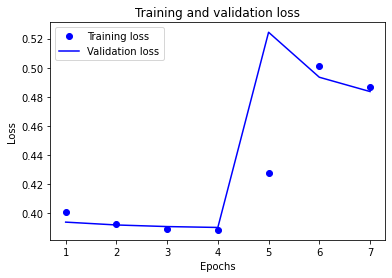

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

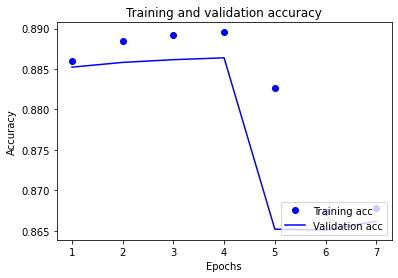

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# BLEU score on test dataset

In [ ]:
# try model without training
scores = []
for input_test_batch, target_test_batch in test_dataset:
    test_batch_predictions = model(input_test_batch)
    scores.append(bleu_score(target_test_batch, test_batch_predictions))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
sum(scores)/len(scores)

0.7573974452896757

In [ ]:
# try model without training
scores = []
for input_test_batch, target_test_batch in test_dataset:
    test_batch_predictions = model(input_test_batch)
    scores.append(bleu_score_bi(target_test_batch, test_batch_predictions))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
sum(scores)/len(scores)

0.48197460643243134

# Inference

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, tokenizer, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.tokenizer = tokenizer

  #@tf.function
  def generate_one_step(self, input_chars, states=None):
    #import pdb; pdb.set_trace()
    # Convert strings to token IDs.
    # input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.tokenizer.texts_to_sequences(input_chars)
    input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, padding='post')

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states_h, states_c = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.tokenizer.sequences_to_texts([predicted_ids.numpy()])

    # Return the characters and model state.
    return predicted_chars, [states_h, states_c]

In [ ]:
one_step_model = OneStep(model, tokenizer)

In [ ]:
start = time.time()
states = None
next_char = ['w']
result = [next_char]

for n in range(2):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

wed 

________________________________________________________________________________

Run time: 0.016946792602539062


In [ ]:
def pwds_from_chars(start_char, len):
  states = None
  next_char = [start_char]
  result = [next_char]

  for n in range(len-1):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

  result = tf.strings.join(result)
  return result[0].numpy().decode('utf-8')

In [ ]:
all_pos = []
while True:
  pred = pwds_from_chars('p', 4)
  if pred not in all_pos:
    all_pos.append(pred)
  else:
    break

print(all_pos)

['paka', 'pplp', 'pook', 'pusa', 'p1x6', 'pari', 'prop', 'payt', 'palo', 'psr0', 'plea', 'peps', 'pedr', 'phat', 'pimy', 'puma', 'pe5a', 'pupp', 'play', 'pakd', 'prin', 'plut', 'pela', 'patr']


In [ ]:
given_pass = 'Password1'
attempts = 1

while True:
  pred = pwds_from_chars(given_pass[0], len(given_pass))
  print(f"{attempts} - {pred}")
  if pred == given_pass:
    break
  attempts += 1

print(f"Model took {attempts} attempts to find password - {given_pass}")

1 - Perno1259
2 - Purice098
3 - Patience4
4 - PJABCrew3
5 - Portdolpi
6 - PraiseHop
7 - PictureWi
8 - P98041065
9 - PISCISTO0
10 - Passer469
11 - Proxlucks
12 - PopyNikes
13 - PANDA69CH
14 - Perry0606
15 - PeggyWigg
16 - Pnel08059
17 - PJ12jqks6
18 - Patsymon1
19 - PLAYBOY22
20 - PxZgtnzQ3
21 - PregleLan
22 - Pointon72
23 - PE4CESEXY
24 - POP214810
25 - PECOASTIO
26 - PROSPECTS
27 - PHONEspoo
28 - PXNDX8285
29 - PLK9999II
30 - PRINCE060
31 - P@nt15tv1
32 - Pfairview
33 - PALMEROAD
34 - PAO714518
35 - PATMC2815
36 - Pknhkl151
37 - PARLA9357
38 - P1d1aCK19
39 - Policia07
40 - PERFECT51
41 - PINKCHOPP
42 - Porkidoho
43 - Paulamarc
44 - P1m1n43v3
45 - PAUL08240
46 - Pineapple
47 - PAUL2004S
48 - PLUS12121
49 - PANERA123
50 - Pa1577971
51 - Pachola27
52 - Piochenta
53 - PREDESTIN
54 - Pussy2065
55 - Paje19802
56 - Potokal60
57 - PLAYBOIBO
58 - Penuta198
59 - PEDROFF10
60 - POUSSTIK5
61 - PRILLURE3
62 - POWEA69CH
63 - Pink424sH
64 - PbismisHe
65 - PASSMORE1
66 - PAINT3228
67 - PANGA3651
68 -

# Attempts calculation

In [ ]:
def find_attempts(given_pwd):
  pass_len = len(given_pwd)
  attempts = 1
  # iterate through each starting letter. 
  for l in tokenizer.word_index.keys():
    states = None
    next_char = [l]
    result = [next_char]

    for n in range(pass_len-1):
      next_char, states = one_step_model.generate_one_step(next_char, states=states)
      result.append(next_char)
    
    result = tf.strings.join(result)
    pred = result[0].numpy().decode('utf-8')
    if pred == given_pwd:
      print(f"Model predicted password in {attempts}")
    else:
      attempts += 1

In [ ]:
find_attempts('war')

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

reference = [['a', 'b', 'c'], ['p','q','r'],[' ']]
candidate = [['a', 'b', 'c'], ['p','q','r'],[' ']]

score = corpus_bleu(reference, candidate)
print(score)

1.0


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
reference = [['a', 'b', 'c'], ['p','q','r'],[' ']]
candidate = [['p','q','r'],['a', 'b', 'c'],[' ']]

score = corpus_bleu(reference, candidate)
print(score)

0.6147881529512643


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
reference = [['a', 'b', 'c'], ['p','q','r'],[' ']]
candidate = [['a', 'b', 'd'], ['p','q','r'],[' ']]

score = corpus_bleu(reference, candidate)
print(score)

0.9621954581957615


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
